In [33]:
import sys

sys.path.append("..")
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import torch
import torchvision
from torch import Tensor, nn, tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import functional as TVF
from utils import bbox, download_extract

# Face Detection

This notebook aims to provide an interface that allows detection of face from input of
image. The interface is described below

In [2]:
def detect_face(image: Image.Image) -> Tensor:
    """Detects the face in the given image and returns the bounding box.

    :param image: The image to detect the face in.
    :return: The bounding box of the face. (number of bbox) x 4 where the 4
        elements are (x0, y0, x1, y1) in the image.
    """


## Load Dataset

### FFDB

In [3]:
import asyncio
from collections import OrderedDict
from pathlib import Path


In [4]:
ffdb_data_dir = Path("data") / "fddb"
ffdb_annotations = ffdb_data_dir / "annotations"
ffdb_images = ffdb_data_dir / "images"


In [5]:
images_url = "http://vis-www.cs.umass.edu/fddb/originalPics.tar.gz"
annotations_url = "http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz"

await asyncio.gather(
    download_extract(images_url, ffdb_images),
    download_extract(annotations_url, ffdb_annotations),
)
print("Done!")


Skipping download of http://vis-www.cs.umass.edu/fddb/originalPics.tar.gz as data\fddb\images already exists
Skipping download of http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz as data\fddb\annotations already exists
Done!


In [6]:
class FFDBDataset(Dataset):
    """Dataset for the FDDB dataset."""

    def __init__(self, path: Path):
        self.files = self.parse_fddb_annotation(path)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx: int) -> tuple[Tensor, Tensor]:
        path, boxes = list(self.files.items())[idx]
        return Image.open((ffdb_images / path).with_suffix(".jpg")), boxes

    @staticmethod
    def parse_fddb_annotation(path: Path) -> OrderedDict[Path, list[Tensor]]:
        """Parse the annotation file for a single image."""

        files: OrderedDict[Path, list[Tensor]] = OrderedDict()
        state: str = "start"
        for line in path.read_text().splitlines():
            line = line.strip()
            if not line:
                continue
            if state == "start":
                files[(path := Path(line))] = []
                state = "count"
            elif state == "count":
                state = int(line)
            else:
                state -= 1
                files[path].append(tensor([float(x) for x in line.split()]))
                if state == 0:
                    state = "start"
                    files[path] = torch.stack(files[path])[..., :5]
        return files


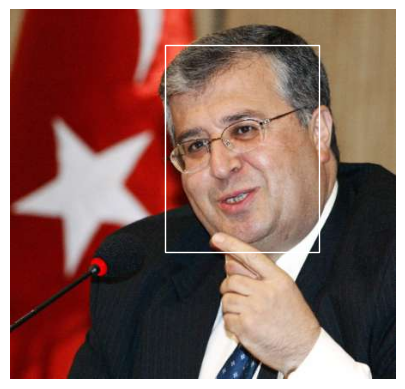

In [7]:
dataset = FFDBDataset(ffdb_annotations / "FDDB-fold-01-ellipseList.txt")
image, boxes = dataset[0]

bbox.show_image(image)
bbox.show_bbox(bbox.ellipse2bbox(boxes), color="w")


### Experiment

In [11]:
banana_data_dir = Path("data") / "banana"
banana_url = "http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip"
await download_extract(banana_url, banana_data_dir)

Extracting data\banana-detection.zip to data\banana


In [18]:
import pandas as pd

banana_train = banana_data_dir / "bananas_train"
label = pd.read_csv(banana_train / "label.csv")


,img_name,label,xmin,ymin,xmax,ymax
0,0.png,0,104,20,143,58
1,1.png,0,68,175,118,223
2,2.png,0,163,173,218,239
3,3.png,0,48,157,84,201
4,4.png,0,32,34,90,86


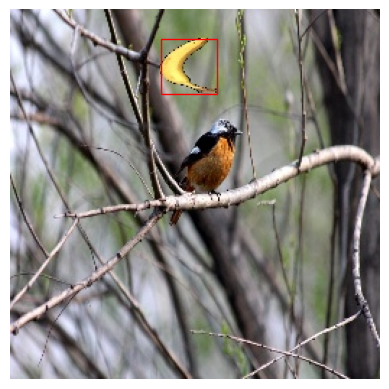

In [37]:
class BananaDataset(Dataset):
    """Dataset for the banana detection dataset."""

    def __init__(self, path: Path):
        self.files = list((path / "images").glob("*.png"))
        self.labels = pd.read_csv(path / "label.csv")
        self.labels2bbox = {
            name: tensor(bbox[["xmin", "ymin", "xmax", "ymax"]].to_numpy()).view(-1, 4)
            for name, bbox in self.labels.groupby("img_name")
        }

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx: int) -> tuple[Tensor, Tensor]:
        path = self.files[idx]
        return TVF.to_tensor(Image.open(path)), self.labels2bbox[path.name]


dataset = BananaDataset(banana_train)
image, boxes = dataset[0]

bbox.show_image(image)
bbox.show_bbox(boxes, color="r")


## SSD Model

In [8]:
def cls_layer(n_input, n_anchor, n_class):
    return nn.Conv2d(n_input, n_anchor * (n_class + 1), kernel_size=3, padding=1)


def bbox_layer(n_input, n_anchor):
    return nn.Conv2d(n_input, n_anchor * 4, kernel_size=3, padding=1)


def flatten_pred(pred):
    """
    Flatten the prediction from the network to (batch_size, n_anchor * (n_class + 1))

    :param pred: The prediction from the network. (batch_size, n_anchor * (n_class + 1), h, w)
    :return: The flattened prediction.
    """

    return pred.permute(0, 2, 3, 1).flatten(start_dim=1)


def concat_pred(preds):
    """
    Concatenate the predictions from the network.

    :param preds: The predictions from the network. (batch_size, n_anchor * (n_class + 1), h, w)
    :return: The concatenated prediction.
    """

    return torch.cat([flatten_pred(pred) for pred in preds], dim=1)


def down_sample_layer(n_input, n_output):
    layers = []
    layers.extend(
        [
            nn.Conv2d(n_input, n_output, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_output),
            nn.ReLU(),
        ]
    )
    layers.extend(
        [
            nn.Conv2d(n_output, n_output, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_output),
            nn.ReLU(),
        ]
    )
    layers.append(nn.MaxPool2d(kernel_size=2))
    return nn.Sequential(*layers)


In [9]:
from torchvision.models import (ResNet18_Weights, ResNet34_Weights, resnet18,
                                resnet34)


class SSD(nn.Module):
    def __init__(self, sizes, ratios, **kwargs):
        super().__init__(**kwargs)

        self.sizes = sizes
        self.ratios = ratios
        self.n_class = 1
        self.n_anchor = len(sizes[0]) + len(ratios[0]) - 1

        cls_layers = []
        bbox_layers = []
        blk_layers = []

        idx2channel = [128, 256, 512, 512, 512]
        for i in range(len(idx2channel)):
            blk: None
            if i == 4:
                blk = nn.AdaptiveAvgPool2d((1, 1))
            elif i == 0:
                rn = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
                blk = nn.Sequential(
                    rn.conv1,
                    rn.bn1,
                    rn.relu,
                    rn.maxpool,
                    rn.layer1,
                    rn.layer2,
                )
            else:
                blk = down_sample_layer(idx2channel[i - 1], idx2channel[i])

            cls_layers.append(cls_layer(idx2channel[i], self.n_anchor, self.n_class))
            bbox_layers.append(bbox_layer(idx2channel[i], self.n_anchor))
            blk_layers.append(blk)

        self.cls_layers = nn.ModuleList(cls_layers)
        self.bbox_layers = nn.ModuleList(bbox_layers)
        self.blk_layers = nn.ModuleList(blk_layers)

    def forward(self, x):
        bs = x.shape[0]
        anchors, cls_preds, bbox_preds = [[] for _ in range(3)]
        for i in range(5):
            x = self.blk_layers[i](x)
            anchors.append(bbox.anchors(x, sizes=self.sizes[i], ratios=self.ratios[i]))
            cls_preds.append(self.cls_layers[i](x))
            bbox_preds.append(self.bbox_layers[i](x))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_pred(cls_preds)
        cls_preds = cls_preds.reshape(bs, -1, self.n_class + 1)
        bbox_preds = concat_pred(bbox_preds)
        bbox_preds = bbox_preds.reshape(bs, -1, 4)
        return anchors, cls_preds, bbox_preds

In [10]:
def test_net():
    net = SSD(
        sizes=[[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]],
        ratios=[[1, 2, 0.5]] * 5,
    )
    X = torch.rand(1, 3, 256, 256)
    anchors, cls_preds, bbox_preds = net(X)
    assert anchors.shape == (1, 5444, 4), "Wrong anchor shape"
    assert cls_preds.shape == (1, 5444, 2), "Wrong class prediction shape"
    assert bbox_preds.shape == (1, 5444, 4), "Wrong bounding box prediction shape"
